TO DO : 

    - Separate data into metadata df and signal dict, so that it is easier to analyse data and to access signal just with key (sample_id) DONE
    -  Check for normal ecgs and train the classifier with AF vs normal (NORMAL ECGS ARE STATED AS SINUS RYTHM)
    - Only 100 samples are loaded for velocity. All should be loaded at the end DONE
    - If waiting time is too long use a sql based system

## Loading data

In [1]:
# !python -V > full_requirements.txt && pip list --format=freeze >> full_requirements.txt

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import joblib
from pathlib import Path
%matplotlib inline

# Import custom modules
from data_processing import load_processed_data


Functions

In [3]:
def classify_cardiac_condition(diagnosis_codes):
    # Normal codes
    normal_codes = ['426783006']  # Normal sinus rhythm

    # Rhythm disorder codes (arrhythmias)
    arrhythmia_codes = [
        '49436004',   # AF
        '164889003',  # Atrial flutter
        '427172004',  # PVC
        '426761007',  # VT
        '284470004',  # PAC
        '164896001',  # VF
        '195126007',  # AT
        '251146004',  # Sinus tachycardia
        '427393009'   # Sinus bradycardia
    ]

    # Conduction disease codes
    conduction_codes = [
        '59118001',   # RBBB
        '28189009',   # LBBB
        '270492004',  # 1st degree AVB
        '445211001',  # 2nd degree AVB
        '27885002'    # Complete heart block
    ]
    
    # Structural/Ischemic codes
    structural_codes = [
        '22298006',   # MI
        '164865005',  # ST elevation
        '164867002',  # ST depression
        '164873001',  # LVH
        '164874007'   # RVH
    ]
    
    if any(code in diagnosis_codes for code in normal_codes):
        return 'Normal'
    elif any(code in diagnosis_codes for code in arrhythmia_codes):
        return 'Arrhythmia'
    elif any(code in diagnosis_codes for code in conduction_codes):
        return 'Conduction'
    elif any(code in diagnosis_codes for code in structural_codes):
        return 'Structural'
    else:
        return 'Other'

Only Execute first time (to define index split)

In [4]:
# # Try loading preprocessed data
# data_path = '/Users/marcpalomer/Documents/Personal/ECG_prediction/Results/processed_data'
# try:
#    ecg_data, patient_data = load_processed_data(data_path)
#    print(f"Loaded data for {len(ecg_data)} patients")
# except (FileNotFoundError, StopIteration):
#    raise FileNotFoundError("Preprocessed data not found. Please run data_processing.py first")


# # Define stratification based on diagnosis
# patient_data['diagnosis_class'] = patient_data['diagnosis_code'].apply(classify_cardiac_condition)

# # Create development and validation sets (70/30 split)
# dev_indices, val_indices = train_test_split(
#     patient_data.index,
#     test_size=0.7,
#     random_state=42,
#     stratify=patient_data['diagnosis_class']
# )

# del ecg_data
# del patient_data

# # Save indices for reproducibility
# np.save('/Results/dev_indices.npy', dev_indices)
# np.save('/Results/val_indices.npy', val_indices)

 ## 2. Initial Data Split

In [5]:
# Load validation indices
dev_indices = np.load('./Results/dev_indices.npy', allow_pickle=True)
val_indices = np.load('./Results/val_indices.npy', allow_pickle=True)


In [6]:
data_path = '/Users/marcpalomer/Documents/Personal/ECG_prediction/Results/processed_data'
try:
   dev_ecg_dict, dev_data = load_processed_data(data_path, indices= dev_indices)
   print(f"Loaded data for {len(dev_data)} patients")
except (FileNotFoundError, StopIteration):
   raise FileNotFoundError("Preprocessed data not found. Please run data_processing.py first")

dev_ecg = {k: v['ecg_signals_filtered'] for k, v in dev_ecg_dict.items()}
del dev_ecg_dict

print("Development set size:", len(dev_indices))
print("Validation set size:", len(val_indices))



Using 7 CPUs for parallel processing
Loading data from: /Users/marcpalomer/Documents/Personal/ECG_prediction/Results/processed_data/processed_20250115_132555


Loading patient data: 100%|██████████| 13545/13545 [00:28<00:00, 478.41patient/s]


Successfully loaded 13545 out of 13545 patients from /Users/marcpalomer/Documents/Personal/ECG_prediction/Results/processed_data/processed_20250115_132555
2025-01-22 20:43:17 - load_processed_data took 0.55 minutes
Loaded data for 13545 patients
Development set size: 13545
Validation set size: 31606


In [7]:
dev_ecg

{'JS39860':                I          II         III         aVR         aVL         aVF  \
 0      24.757664   39.755189   14.924248  -32.515168    5.269304   27.581105   
 1      37.146640   37.483773   -1.217461  -37.987494   17.468575   15.823553   
 2      33.877790   29.702617   -5.343235  -32.719585   18.493337   10.215643   
 3      28.567011   25.834693   -3.055691  -27.341277   16.654305   10.822514   
 4      37.707705   32.644687   -5.522876  -34.298418   22.519552   13.036560   
 ...          ...         ...         ...         ...         ...         ...   
 4995  -40.803505  403.282929  442.709304 -180.046262 -241.269814  426.195019   
 4996    5.165483  314.642090  308.674456 -157.598702 -151.702972  314.004901   
 4997   88.117684  270.704017  182.002422 -178.156999  -46.612485  228.302626   
 4998  127.326493  254.450002  126.588253 -191.191151    0.880399  192.012033   
 4999   99.894081  244.639919  144.901044 -172.365855  -22.820608  195.244936   
 
               

In [8]:
dev_data

,age,sex,diagnosis_code,diagnosis_name
JS00067,77.0,Male,"['164889003', '55827005', '428750005']","['Atrial Fibrillation', 'Left Ventricular Hype..."
JS00104,68.0,Male,['426177001'],['Sinus Bradycardia']
JS00058,63.0,Female,['426783006'],['Sinus Rhythm (Normal)']
JS00059,39.0,Female,"['427084000', '428750005']","['Sinus Tachycardia', 'ST-T Change']"
JS00065,60.0,Male,['426177001'],['Sinus Bradycardia']
...,...,...,...,...
JS45525,0.0,Male,['425856008'],NaN
JS45521,0.0,Female,['425856008'],NaN
JS45535,62.0,Female,['425856008'],NaN
JS45536,48.0,Male,['425856008'],NaN


## Illness distribution and data filtering

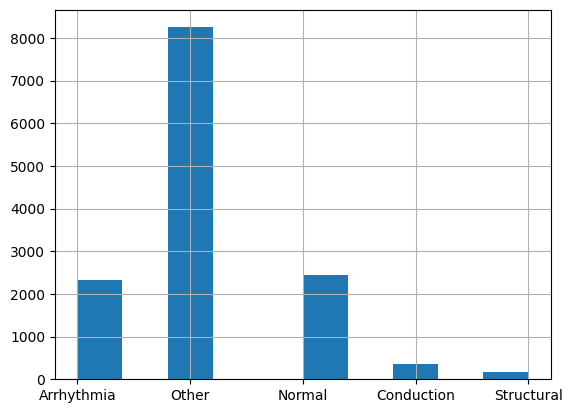

In [9]:
# Apply to dataframe
dev_data['cardiac_condition'] = dev_data['diagnosis_code'].apply(classify_cardiac_condition)
dev_data['cardiac_condition'].hist()
plt.show()

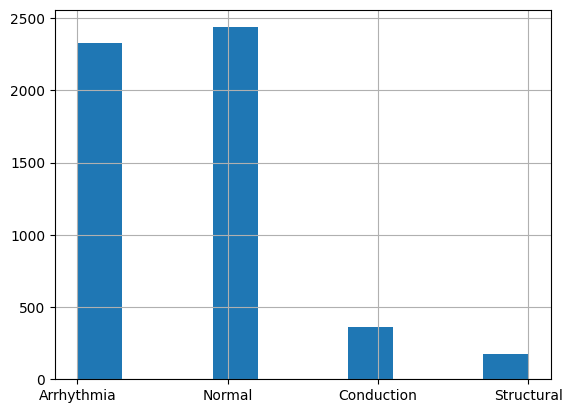

In [10]:
# First filter patient_data
dev_data_filtered = dev_data[dev_data['cardiac_condition'] != 'Other']
dev_data_filtered['cardiac_condition'].hist()
plt.show()

In [11]:
# Then filter ecg_data to only keep patients in the filtered patient_data
dev_ecg_filtered = {
    patient_id: data 
    for patient_id, data in dev_ecg.items() 
    if patient_id in dev_data_filtered.index
}

print(f"Original ECG records: {len(dev_ecg)}")
print(f"Filtered ECG records: {len(dev_ecg_filtered)}")

Original ECG records: 13545
Filtered ECG records: 5297


### HRV calculation in lead II (gold standard) (it is a time saries for patient so like a new lead...)

In [12]:
import neurokit2 as nk
import numpy as np

def validate_rpeaks(rpeaks, fs):
    # Remove physiologically impossible R-peaks
    rr_intervals = np.diff(rpeaks) / fs
    valid_rr = (rr_intervals >= 0.2) & (rr_intervals <= 2.0)  
    valid_peaks = rpeaks[1:][valid_rr]
    return valid_peaks

def calculate_hr_metrics(rpeaks, fs):
    rr_intervals = np.diff(rpeaks) / fs
    hr = 60 / rr_intervals
    return np.median(hr), np.mean(hr), np.std(hr), np.min(hr), np.max(hr)

def calculate_heartrate(record, fs):
    # Find R-peaks using neurokit2
    rpeaks = list(nk.ecg_findpeaks(record, sampling_rate=fs).values())[0]
    rpeaks = validate_rpeaks(rpeaks, fs)
    return calculate_hr_metrics(rpeaks, fs)

def add_hr_metrics(patient_data, ecg_data):
    metrics = {'median_hr': [], 'mean_hr': [], 'std_hr': [], 'min_hr': [], 'max_hr': []}
    
    for id in patient_data.index:
        if id in ecg_data:
            lead_II = ecg_data[id].loc[:,'II']
            try:
                median_hr, mean_hr, std_hr, min_hr, max_hr = calculate_heartrate(lead_II, fs=500)
            except:
                median_hr, mean_hr, std_hr, min_hr, max_hr = [np.nan,np.nan,np.nan,np.nan,np.nan]
            metrics['median_hr'].append(median_hr)
            metrics['mean_hr'].append(mean_hr)
            metrics['std_hr'].append(std_hr)
            metrics['min_hr'].append(min_hr)
            metrics['max_hr'].append(max_hr)
        else:
            for key in metrics:
                metrics[key].append(None)
    
    for metric, values in metrics.items():
        patient_data[metric] = values
    
    return patient_data

dev_hrv = add_hr_metrics(dev_data_filtered, dev_ecg_filtered)

/opt/anaconda3/envs/marc_priv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/marc_priv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/marc_priv/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/marc_priv/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/marc_priv/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/5d/dpg2yjr900b41jg1818s56740000gn/T/ipykernel_3353/2

In [13]:
# import automatic_reporting as AR 
# reportName = "Patient Data and HRV"
analyse_features= ['median_hr',	'mean_hr','std_hr',	'min_hr', 'max_hr', 'age']
# control_features= ['sex', 'arrhythmia', 'Healthy']




# PATH = '.'

# report_builder = AR.AutoReport(main_path = f"{PATH}",
#                                     data = patient_data,
#                                     analyse_features= analyse_features,
#                                     control_features= control_features)

# report_builder.generate_report(ReportName = reportName)

# Dumb classifier

In [14]:
ML_dataset = dev_hrv[analyse_features+['cardiac_condition']]
# arrythmia_ml_dataset = ML_dataset[ML_dataset['cardiac_condition'].isin(['Normal','Arrhythmia'])]
ML_dataset.value_counts('cardiac_condition')

cardiac_condition
Normal        2437
Arrhythmia    2327
Conduction     359
Structural     174
Name: count, dtype: int64

In [15]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report
# from sklearn.model_selection import cross_validate
# from sklearn.pipeline import Pipeline



# def quick_classify(df, target_col, features=None):
#     """
#     Quick classification using RandomForest with minimal preprocessing.
    
#     Args:
#         df: pandas DataFrame with your data
#         target_col: name of the column to predict
#         features: list of feature columns to use (optional, uses all except target if None)
#     """
#     # Select features
#     if features is None:
#         features = [col for col in df.columns if col != target_col]
    
#     # Prepare data
#     X = df[features]
#     y = df[target_col]
    
#     # Handle non-numeric columns
#     # X = pd.get_dummies(X)
    
#     # Split data
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
#     # Scale features
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
    
#     # Train model
#     model = RandomForestClassifier(n_estimators=100, random_state=42)
#     model.fit(X_train_scaled, y_train)
    
#     # Evaluate
#     y_pred = model.predict(X_test_scaled)
#     print(classification_report(y_test, y_pred))
    
#     return {
#         'model': model,
#         'scaler': scaler,
#         'features': X.columns.tolist()
#     }

# quick_classify_dict = quick_classify(ML_dataset, target_col='diagnosis_code')
# quick_classify_dict

In [16]:
from sklearn.model_selection import train_test_split
import RF_pipeline

def prepare_data(df, target_col, features=None, test_size=0.2, random_state=42):
    """Main function to analyze the model."""
    if features is None:
        features = [col for col in df.columns if col != target_col]
    
    X = df[features]
    y = df[target_col]

    analyzer = RF_pipeline.RandomForestAnalyzer()
    visualizer = RF_pipeline.ModelVisualizer()
    # Preprocess data
    X_processed, y_processed, y_mapping = analyzer.preprocess(X,y)
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=test_size, random_state=random_state)
    


    return X_train, X_test, y_train, y_test, y_mapping, analyzer, visualizer, features
   
X_train, X_test, y_train, y_test, y_mapping, analyzer, visualizer, features = prepare_data(df=ML_dataset, target_col='cardiac_condition', features=None)

In [17]:
features

['median_hr', 'mean_hr', 'std_hr', 'min_hr', 'max_hr', 'age']

# Explain what we are doing here

In [18]:
y_train

array([0, 3, 0, ..., 2, 3, 1], dtype=int8)

2025-01-22 20:43:22 - cross_validate took 0.03 minutes


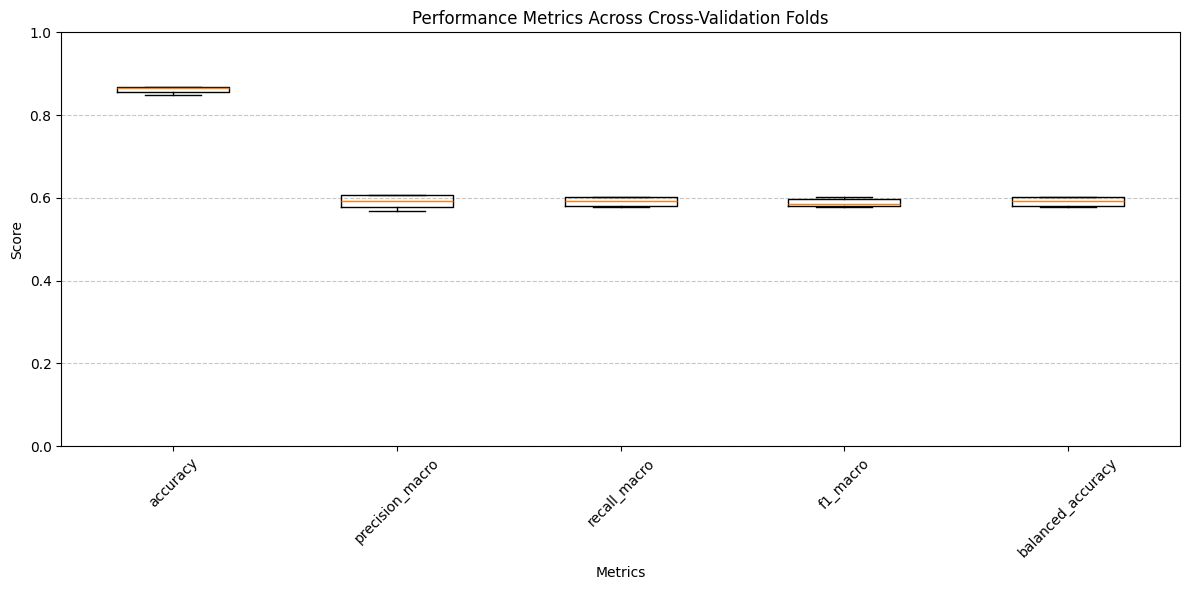


Cross-Validation Metrics Summary:
Accuracy:
  Mean: 0.8608
  Std:  0.0081
Precision_macro:
  Mean: 0.5909
  Std:  0.0150
Recall_macro:
  Mean: 0.5910
  Std:  0.0105
F1_macro:
  Mean: 0.5888
  Std:  0.0095
Balanced_accuracy:
  Mean: 0.5910
  Std:  0.0105
test_accuracy:
  Mean: 0.8608
  Std:  0.0081
test_precision_macro:
  Mean: 0.5909
  Std:  0.0150
test_recall_macro:
  Mean: 0.5910
  Std:  0.0105
test_f1_macro:
  Mean: 0.5888
  Std:  0.0095
test_balanced_accuracy:
  Mean: 0.5910
  Std:  0.0105


In [19]:
# Perform cross-validation
cv_results = analyzer.cross_validate(X_train, y_train)

# Visualize cross-validation results
visualizer.plot_cv_results(scores=cv_results, multiclass=True)

# Optional: Print detailed metrics
for metric in ['test_accuracy', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro', 'test_balanced_accuracy']:
    print(f"{metric}:")
    print(f"  Mean: {np.mean(cv_results[metric]):.4f}")
    print(f"  Std:  {np.std(cv_results[metric]):.4f}")

In [20]:
y_mapping

{0: 'Arrhythmia', 1: 'Conduction', 2: 'Normal', 3: 'Structural'}

2025-01-22 20:43:22 - get_fitted_model took 0.00 minutes


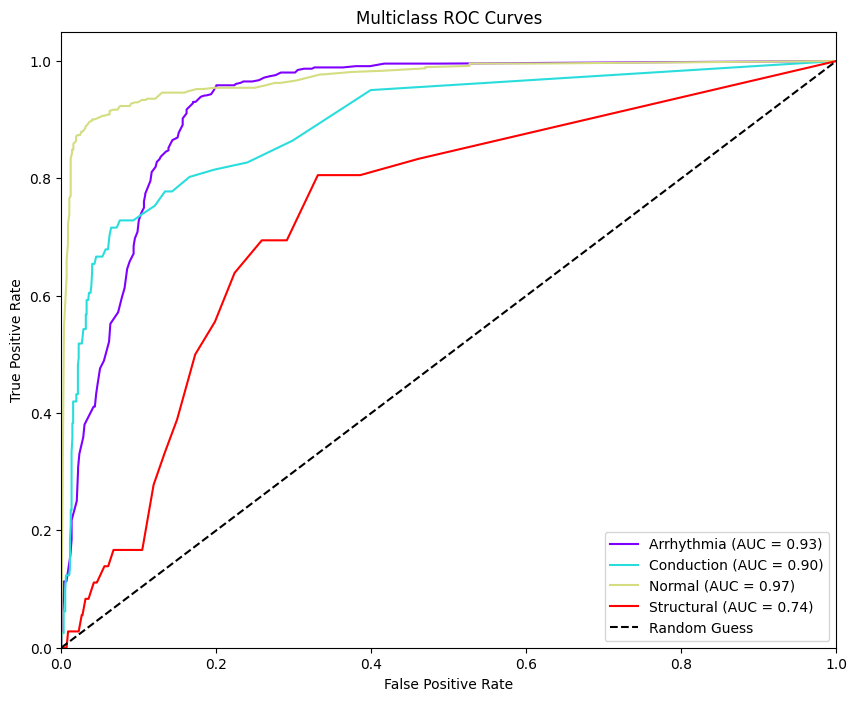


Class-wise AUC:
Arrhythmia: 0.9257
Conduction: 0.8953
Normal: 0.9715
Structural: 0.7395


In [21]:
# Train the model
rf_model = analyzer.get_fitted_model(X_train, y_train)

# Predict probabilities on test set
y_pred_proba = rf_model.predict_proba(X_test)

# Get class names from encoding dictionary
classes = list(y_mapping.values())

# Plot multiclass ROC curves
roc_auc = visualizer.plot_multiclass_roc(y_test, y_pred_proba, classes)

# Print AUC for each class
print("\nClass-wise AUC:")
for cls, auc_val in zip(classes, roc_auc.values()):
    print(f"{cls}: {auc_val:.4f}")

## Decision boundary display

# Correct for multiclasses

/opt/anaconda3/envs/marc_priv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/var/folders/5d/dpg2yjr900b41jg1818s56740000gn/T/ipykernel_3353/3307643721.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set1', len(class_names))


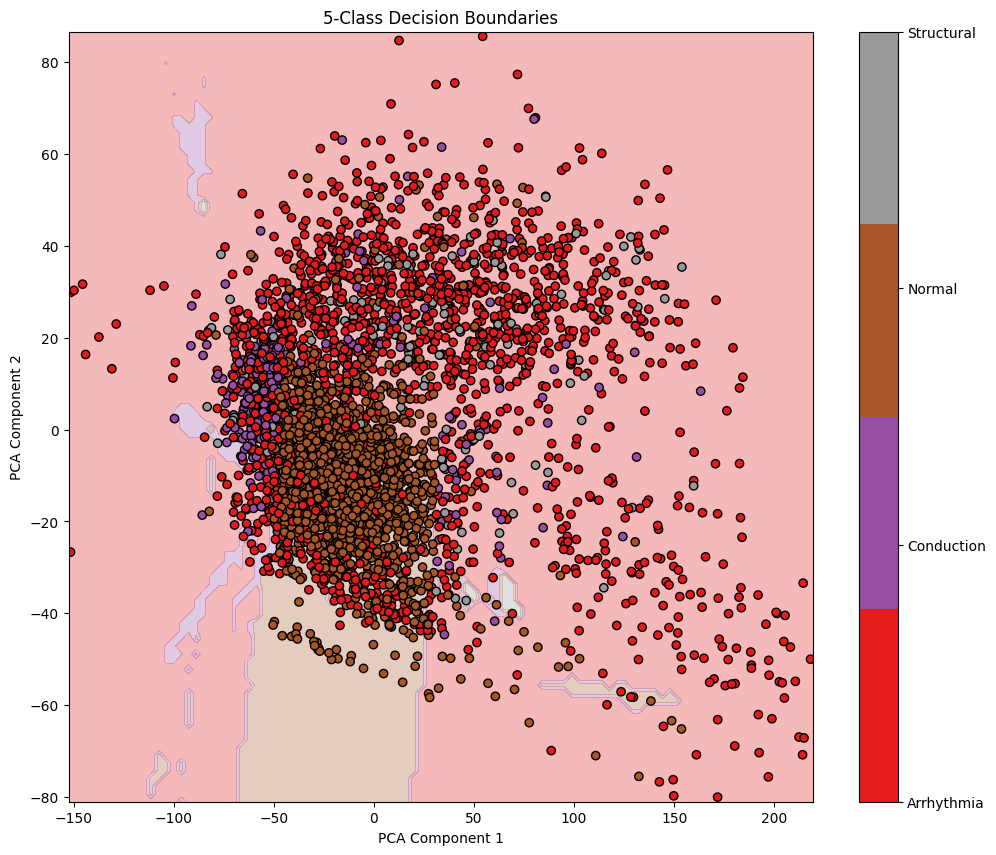

In [22]:
from sklearn.decomposition import PCA

def plot_5class_decision_space(X, y, model, class_names):
    # PCA reduction
    reducer = PCA(n_components=2)
    X_reduced = reducer.fit_transform(X)
    
    # Create mesh grid
    x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
    y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 100),
        np.linspace(y_min, y_max, 100)
    )
    
    # Reconstruct original feature space
    grid_reduced = np.c_[xx.ravel(), yy.ravel()]
    grid_original = reducer.inverse_transform(grid_reduced)
    
    # Predict classes for mesh grid
    Z = model.predict(grid_original).reshape(xx.shape)
    
    plt.figure(figsize=(12, 10))
    
    # Use discrete colormap for categorical data
    cmap = plt.cm.get_cmap('Set1', len(class_names))
    
    # Plot decision regions with discrete colors
    plt.contourf(xx, yy, Z, levels=len(class_names)-1, 
                 cmap=cmap, alpha=0.3)
    
    # Scatter plot of original points
    scatter = plt.scatter(
        X_reduced[:, 0], 
        X_reduced[:, 1], 
        c=y, 
        cmap=cmap,
        edgecolor='black'
    )
    
    # Create colorbar with actual class names
    cbar = plt.colorbar(scatter, ticks=range(len(class_names)))
    cbar.set_ticklabels(class_names)
    
    plt.title('5-Class Decision Boundaries')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()
    
    return X_reduced

# Usage example
class_names = list(y_mapping.values())
X_pca = plot_5class_decision_space(X_train, y_train, model=rf_model, class_names=class_names)

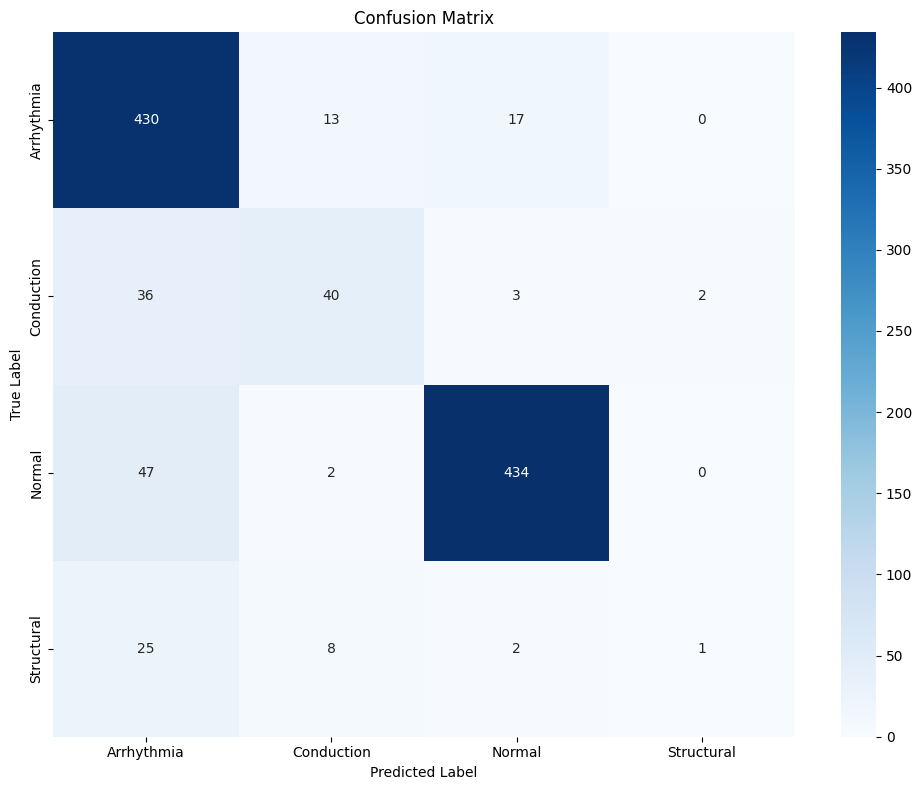

              precision    recall  f1-score   support

  Arrhythmia       0.80      0.93      0.86       460
  Conduction       0.63      0.49      0.56        81
      Normal       0.95      0.90      0.92       483
  Structural       0.33      0.03      0.05        36

    accuracy                           0.85      1060
   macro avg       0.68      0.59      0.60      1060
weighted avg       0.84      0.85      0.84      1060



In [23]:
y_pred = rf_model.predict(X_test)
visualizer.plot_multiclass_confusion_matrix(y_test, y_pred, list(y_mapping.values()))

## Shap values: 
- What favours arrythmia?

In [24]:
# import shap


# X_sub = shap.sample(X_train)
# explainer = shap.Explainer(rf_model.predict_proba, X_sub)
# shap_values = explainer(X_test)

# class_index = 1
# data_index = 1

# shap.plots.waterfall(shap_values[data_index,:,class_index], )

# shap.initjs()
# shap.plots.force(shap_values[data_index,:,class_index])

# shap.plots.beeswarm(shap_values[:,:,class_index])

# shap.plots.bar(shap_values[:,:,class_index])

# shap.plots.scatter(shap_values[:, 'max_hr',1])

# shap.plots.scatter(shap_values[:, 'max_hr',1], color=shap_values[:,:,1])

# Train final ML dataset

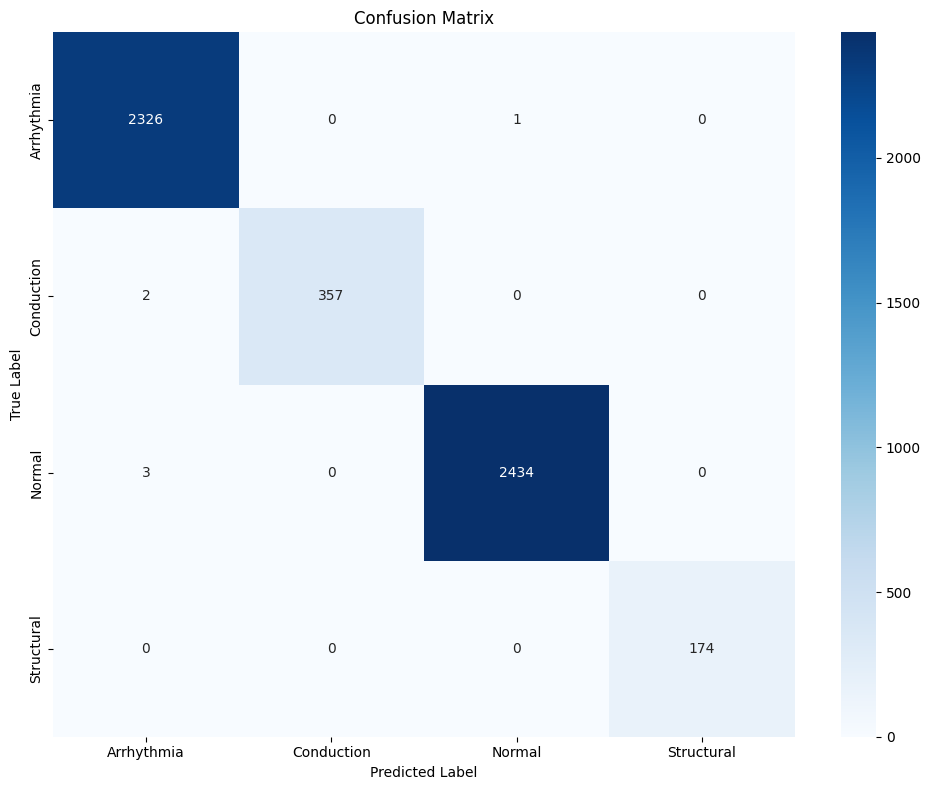

              precision    recall  f1-score   support

  Arrhythmia       1.00      1.00      1.00      2327
  Conduction       1.00      0.99      1.00       359
      Normal       1.00      1.00      1.00      2437
  Structural       1.00      1.00      1.00       174

    accuracy                           1.00      5297
   macro avg       1.00      1.00      1.00      5297
weighted avg       1.00      1.00      1.00      5297



In [25]:
# Prepare full training data
X_full_train = pd.concat([X_train, X_test])
y_full_train = np.concatenate([y_train, y_test])

# Train final model
final_model = RF_pipeline.RandomForestClassifier(
    n_estimators=100, 
    random_state=42
)
final_model.fit(X_full_train, y_full_train)

# Optional: Save the model
joblib.dump(final_model, './Results/final_ml_model.joblib')

# Verify model performance
y_pred = final_model.predict(X_full_train)
visualizer.plot_multiclass_confusion_matrix(y_full_train, y_pred, list(y_mapping.values()))

# Save final model

In [26]:
# After training
analyzer = RF_pipeline.RandomForestAnalyzer()
analyzer.save_model(final_model, X_full_train)

Model saved in: Results/RF_model/results_20250122_204323


'Results/RF_model/results_20250122_204323'

# DL CNN prediction: 
- Will we beat HRV RF classification?


## Pipeline Structure

### Training Phase
1. **Data Preparation**
  - Raw ECG dictionary + labels → `prepare_data()` → `normalize_signals()`
  - Train/val/test split
  - Dataset & DataLoader creation for batching

2. **Training Cycle**
  - DataLoader feeds batches to ModelTrainer
  - Forward pass through ECGNet
  - Loss calculation, backpropagation
  - Validation performance check
  - Save best model
  - Track metrics history

### Evaluation Phase
1. **Model Assessment**
  - Load best model weights
  - Full forward pass on test set
  - Generate predictions/probabilities

2. **Results**
  - Performance metrics calculation
  - Visualization generation
  - Save all results

## DL Architecture

### Input Processing
- 12-lead ECG signals
- 5000 timepoints per lead
- Normalized per lead

### Feature Extraction
- Conv1d (k=50): QRS complex detection
- Conv1d (k=7): Wave morphology
- Conv1d (k=5): Fine details
- Increasing channels (12→32→64→128) for feature hierarchy

### Each Conv Block
- BatchNorm: Training stability
- ReLU: Non-linearity
- MaxPool: Dimension reduction

### Classification
- AdaptivePool: Fixed output size
- FC layers (6400→256→64→2)
- Dropout layers prevent overfitting
- Output: Binary classification probabilities

Label encoding

In [27]:
# Prepare your labels
dev_labels_filtered = dev_data_filtered['cardiac_condition'].reset_index(drop=False)
dev_labels_filtered = dev_labels_filtered.rename(columns={'cardiac_condition':'label'})

# Save categories before encoding
categories = pd.Categorical(dev_labels_filtered['label']).categories

# Encode labels
dev_labels_filtered['label'] = pd.Categorical(dev_labels_filtered['label']).codes
dev_labels_filtered=dev_labels_filtered.set_index('index')

# Create and print the encoding dictionary
encoding_dict = dict(enumerate(categories))

print("\nLabel encoding dictionary:")
for code, label in encoding_dict.items():
    print(f"{label} -> {code}")

print("\nLabel distribution:")
print(dev_labels_filtered['label'].value_counts())


Label encoding dictionary:
Arrhythmia -> 0
Conduction -> 1
Normal -> 2
Structural -> 3

Label distribution:
label
2    2437
0    2327
1     359
3     174
Name: count, dtype: int64


## Data preparation

In [28]:
# Assuming your data is in a dictionary like {patient_id: DataFrame(500x12)}
signals = []
for patient_id in dev_ecg_filtered:
    df = dev_ecg_filtered[patient_id]
    signal = df.values.T  # Transpose to get (12, 500)
    signals.append(signal)

signals = np.array(signals)  # Shape: (n_patients, 12, 500)
labels = np.array([dev_labels_filtered[pid] for pid in dev_labels_filtered.keys()])[0]

In [29]:
signals.shape

(5297, 12, 5000)

In [30]:
labels

array([0, 2, 0, ..., 0, 0, 0], dtype=int8)

### DL model loading (or training)

In [31]:
# Store variables to keep
keep = ['importlib', 'CNN_pipeline', 'tf','np','train_test_split','model', 'X_val', 'y_val', 'signals', 'labels', 'y_mapping']
import gc

def clean_memory(keep_vars=[]):
   """
   Free memory while keeping specified variables.
   Args:
       keep_vars (list): Names of variables to keep
   """
   # Store variables to keep
   saved = {var: globals()[var] for var in keep_vars if var in globals()}
   
   # Clear globals
   for var in list(globals()):
       if var not in ['gc', 'clean_memory'] + keep_vars:
           del globals()[var]
           
   # Restore saved variables
   globals().update(saved)
   
   # Force garbage collection
   gc.collect()

# Usage example:
clean_memory(keep)

In [32]:
import importlib
import CNN_pipeline
# importlib.reload(CNN_pipeline)
# import tensorflow as tf
# import numpy as np
# from sklearn.model_selection import train_test_split


In [33]:
# Initialize model
model = CNN_pipeline.ECGClassifier(
    input_shape=(signals.shape[1], signals.shape[2]), 
    encode_dict=y_mapping
)

X_train, X_val, y_train, y_val = train_test_split(signals, labels, test_size=0.25)
del signals
del labels
del X_train
del y_train


/opt/anaconda3/envs/marc_priv/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [34]:


# # Train
# history = model.train(X_train, y_train, X_val, y_val)
# Load weights
model.load_model('./Results/final_CNN_model/best_model.keras')


/opt/anaconda3/envs/marc_priv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/opt/anaconda3/envs/marc_priv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


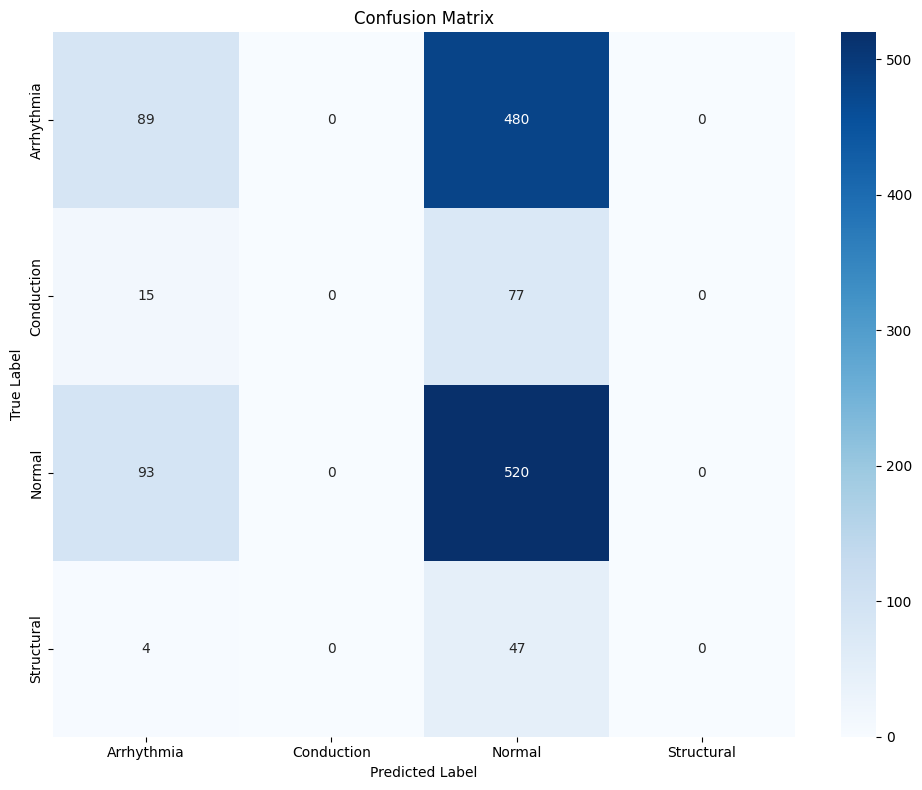

              precision    recall  f1-score   support

  Arrhythmia       0.44      0.16      0.23       569
  Conduction       0.00      0.00      0.00        92
      Normal       0.46      0.85      0.60       613
  Structural       0.00      0.00      0.00        51

    accuracy                           0.46      1325
   macro avg       0.23      0.25      0.21      1325
weighted avg       0.40      0.46      0.38      1325



/opt/anaconda3/envs/marc_priv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/marc_priv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/marc_priv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

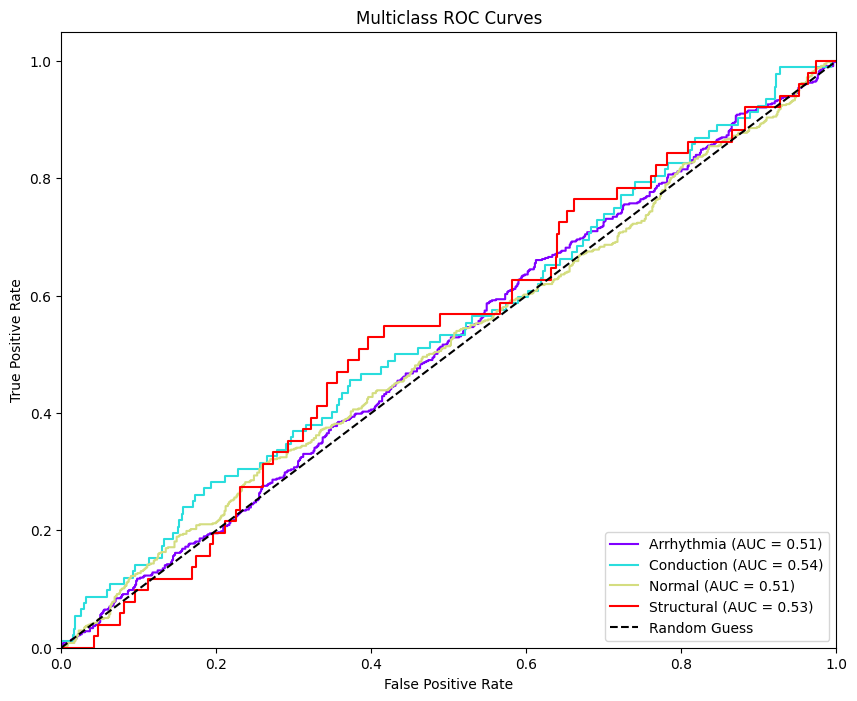

In [35]:
# Evaluate
metrics = model.evaluate(X_val, y_val)